# Vanilla echo-state network

The goal of this exercise is to get some intuition about the functioning of echo-state networks.

Uncomment this line to install ANNarchy if you haven't already:

In [1]:
#!pip install ANNarchy


Let's start by importing numpy, matplotlib and ANNarchy:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann
ann.clear()

ANNarchy 4.8 (4.8.0) on darwin (posix).


Recurrent ESN neurons are defined by a variable $x$ following this ODE:

$$
    \tau \, \dfrac{d x}{dt} + x = \sum_\text{inputs} w_i \, r_i + \sum_\text{recurrent} w_i \, r_i
$$

where $\tau$ is a time constant. They integrate two sorts of inputs, coming from input neurons and the other recurrent neurons.

The firing rate $r$ of a neuron applies the `tanh` function on $x$:

$$
    r = \tanh{x}
$$

The following cell defines such a neuron in ANNarchy:

In [3]:
ESN_Neuron = ann.Neuron(
    parameters = """
        tau = 30.0     : population   # Time constant
        g = 1.0        : population   # Scaling
    """,
    equations="""
        tau * dx/dt + x = sum(in) + g * sum(exc)
        r = tanh(x)
    """
)

An ESN is typically composed of an input population, the reservoir with random recurrent connections and a readout population linearly reading the reservoir's activity:

$$
    \mathbf{z} = W^\text{out} \times \mathbf{r}
$$

The following class defines an input population with a single neuron and a reservoir of `N` neurons. The readout population will be implemented externally.

The weights between the input and recurrent populations are randomly drawn from $\mathcal{N}(0, 1)$. The recurrent weights are drawn from $\mathcal{N}(0, \dfrac{1}{\sqrt{N}})$.

The scaling factor $g$ is integrated in the neuron definition, what allows to vary it easily without redrawing the random weights.

The `trial()` method allows to simulate the ESN for a single trial. After a reset period of 100 ms, an impulse is set in the input population for 100 ms. The ESN relayes for the rest of the trial (duration - 200 ms). The monitor `m` records the firing `r` in the recurrent population and returns it. 

In [4]:
class ESN:
    """
    Echo-state network implemented in ANNarchy.
    """
    def __init__(self, N:int):
        """
        Args:
            N : number of neurons in the reservoir
        """
        self.N = N

        # Input population
        self.inp = ann.Population(1, ann.Neuron(parameters="r=0.0"))

        # Recurrent population
        self.pop = ann.Population(N, ESN_Neuron)

        # Input weights
        self.Wi = ann.Projection(self.inp, self.pop, 'in')
        self.Wi.connect_all_to_all(weights=ann.Normal(0.0, 1.0))

        # Recurrent weights
        self.Wrec = ann.Projection(self.pop, self.pop, 'exc')
        self.Wrec.connect_all_to_all(weights=ann.Normal(0., 1/np.sqrt(N)))

        # Monitor
        self.monitor = ann.Monitor(self.pop, 'r')

        ann.compile()

    def trial(self, g:float, duration:int=5000, amplitude:float=1.0):
        """
        Runs a single trial for a given spectral radius.
        
        Args:
            g: scaling factor.
            duration: duration of the trial.
            amplitude: amplitude of the impulse.
        """

        # Reset and set spectral radius
        self.inp.r = 0.0
        self.pop.x = 0.0
        self.pop.r = 0.0
        self.pop.g = g
        
        # 100 ms of reset
        ann.simulate(100.)
        
        # 100 ms of stimulation
        self.inp.r = amplitude
        ann.simulate(100.0)
        
        # Relax for the rest of the duration
        self.inp.r = 0.0
        ann.simulate(duration - 200.)
        
        # Return the firing rates r
        data = self.monitor.get('r')    
        return data

In [5]:
net = ESN(N=500)

Compiling ...  OK 


**Q:** Run the network for multiple values of $g$ for 5 seconds, with an impulse of amplitude 1.0. Plot the firing rate of a handful of neuron (e.g. 5) and observe the influence of $g$ on the dynamics. When do complex dynamics appear?

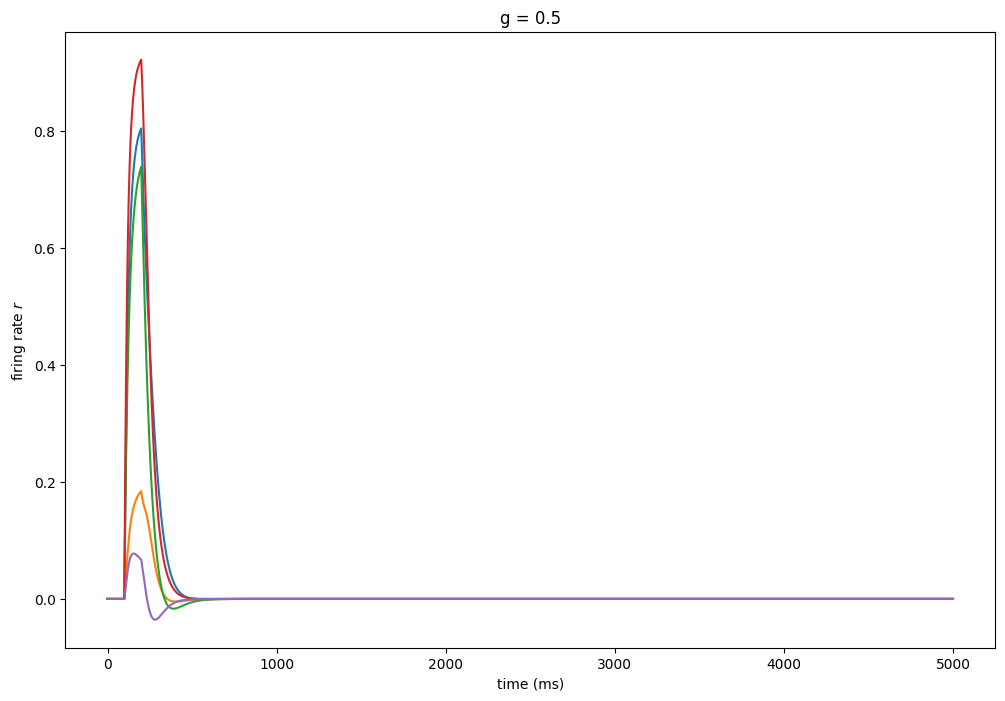

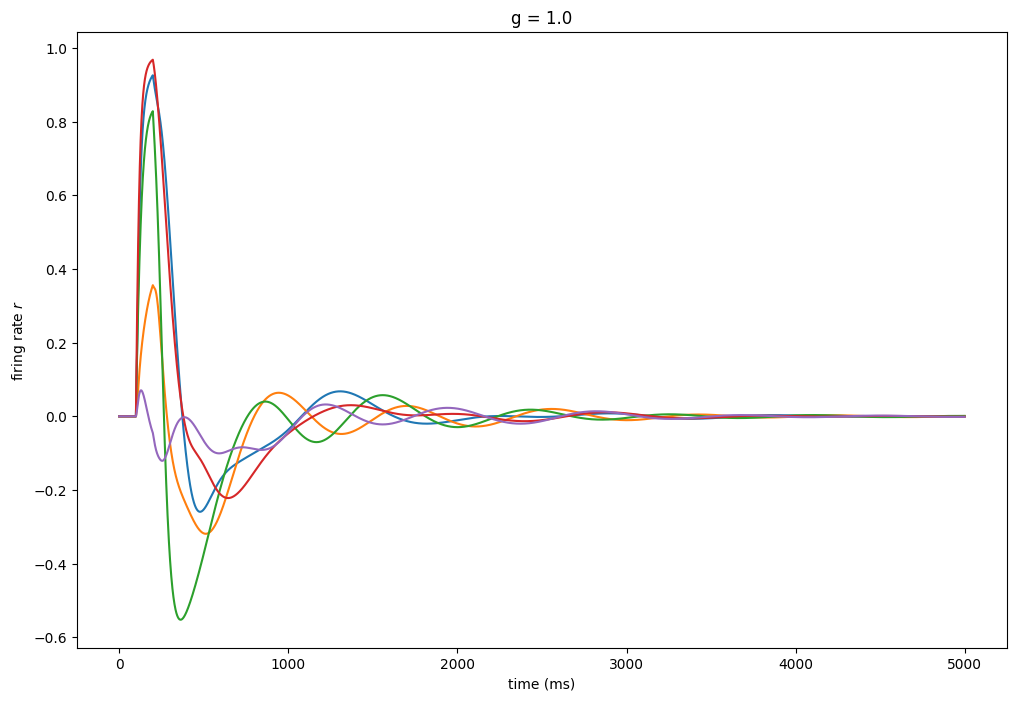

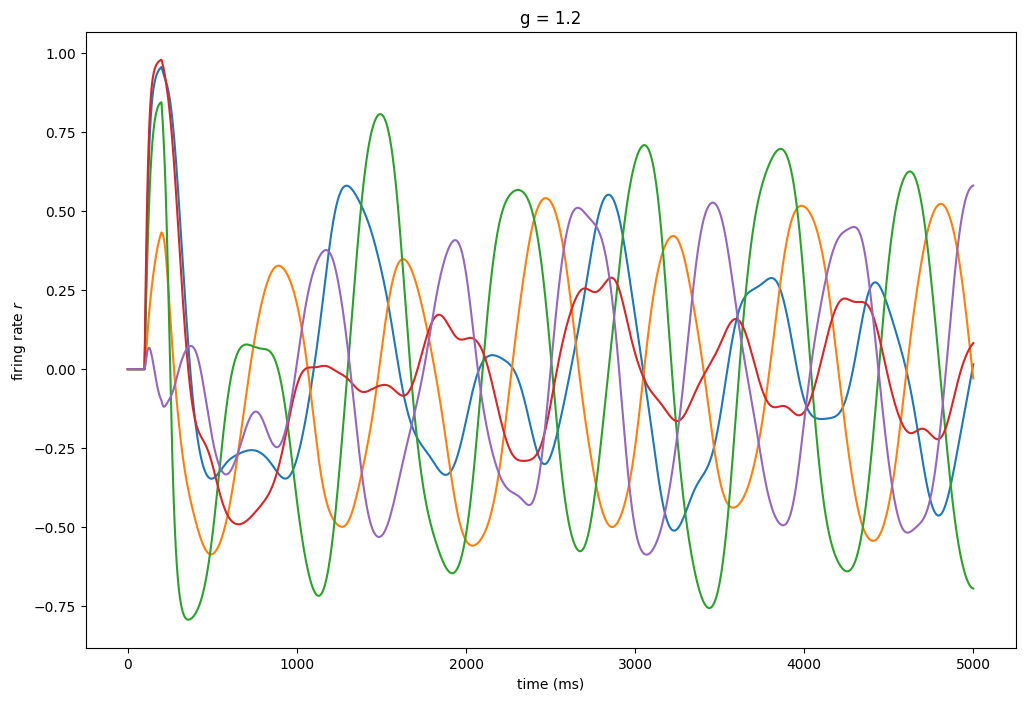

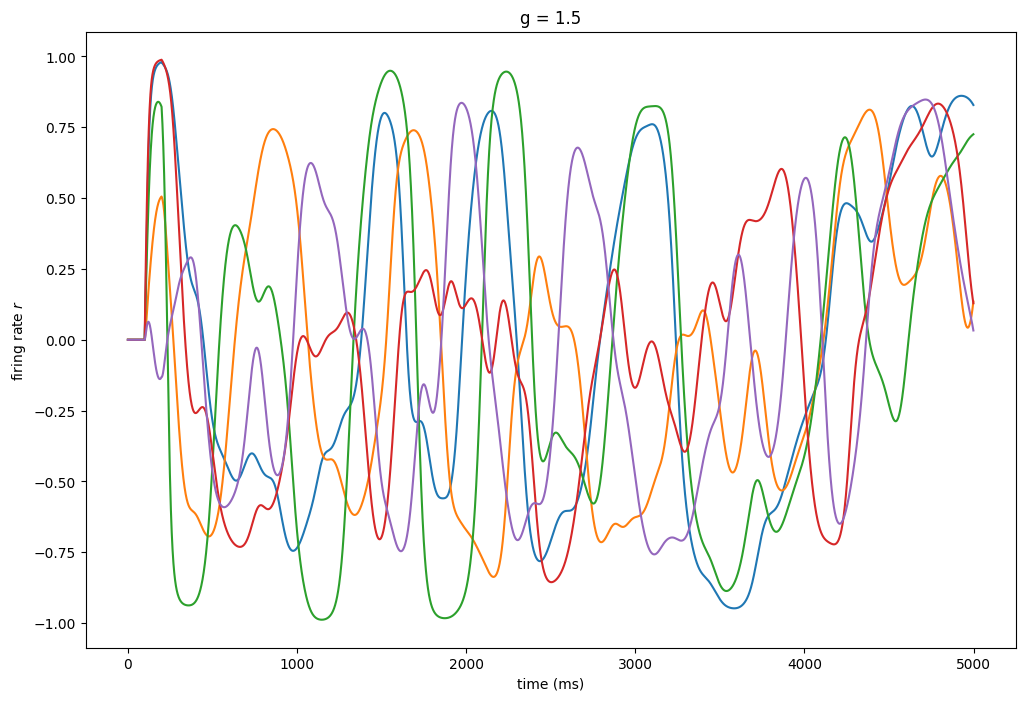

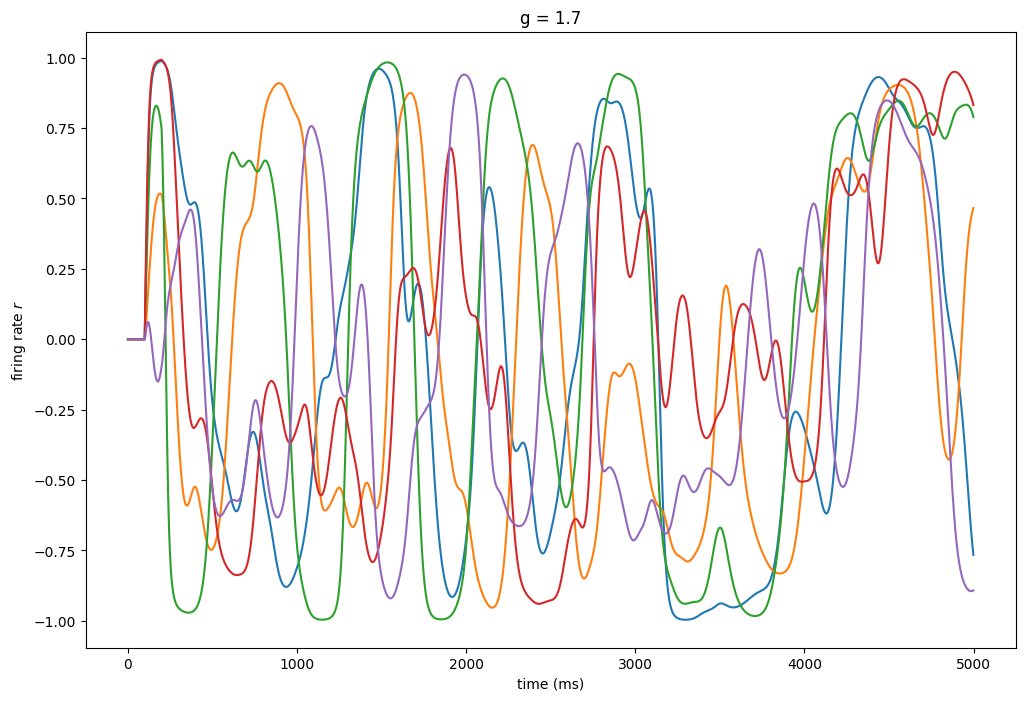

In [6]:
for g in [0.5, 1.0, 1.2, 1.5, 1.7]:

    data = net.trial(g=g, duration=5000, amplitude=1.0)

    fig = plt.figure(figsize=(12, 8))

    for n in range(5):
        plt.plot(data[:, n])

    plt.title("g = "+str(g))
    plt.xlabel('time (ms)')
    plt.ylabel('firing rate $r$')


**A:** The story from the lectures slides is not quite true, it depends quite a lot on the initial weights, but globally you have fading activities for $g<1$ and chaotic activities for $g>1.5$.

**Q:** For different values of $g$, run two trials of the same network: one where the amplitude of the impulse is 1.0, the other where it is very slightly different (e.g. 1.00001). Plot the difference between the two runs. When does chaos appear? Do not hesitate to simulate for longer.

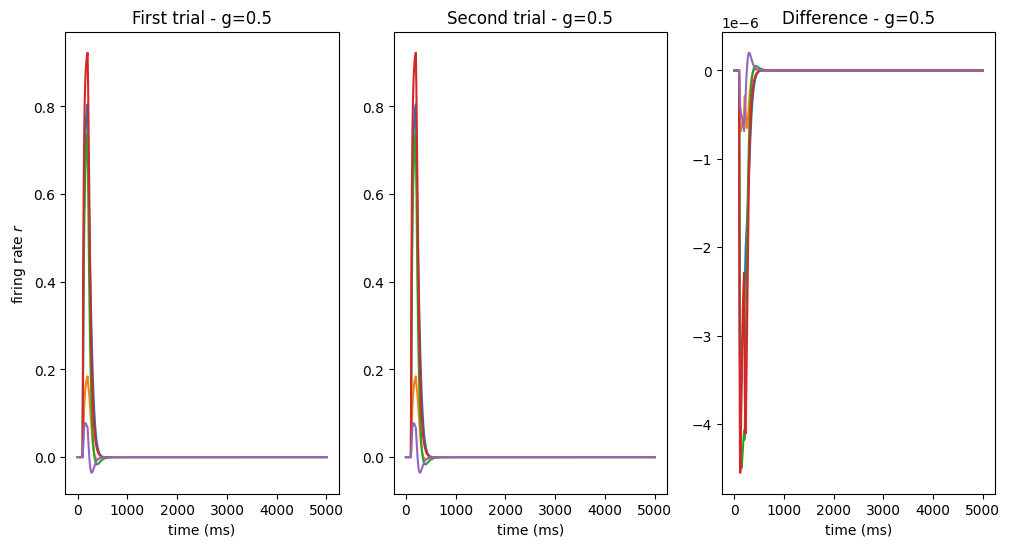

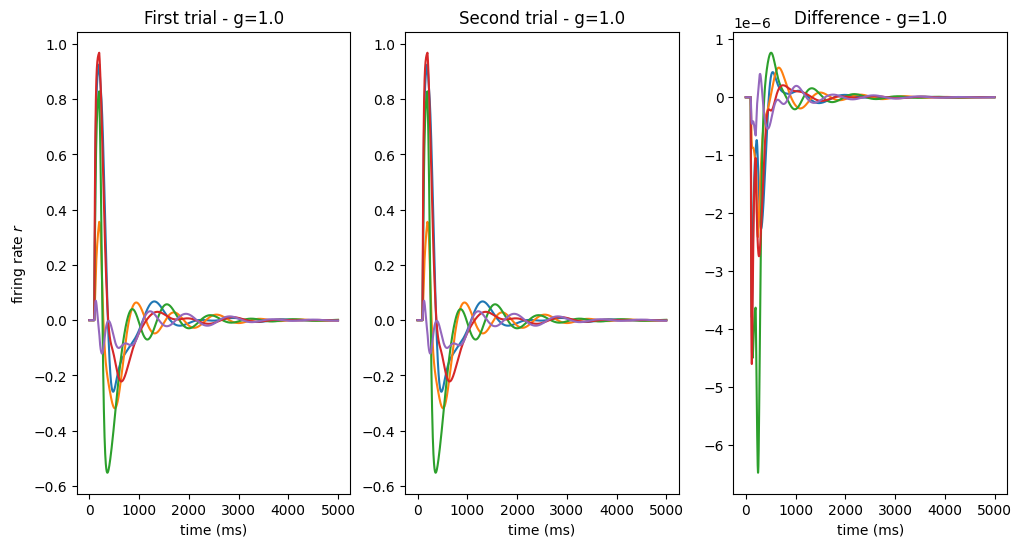

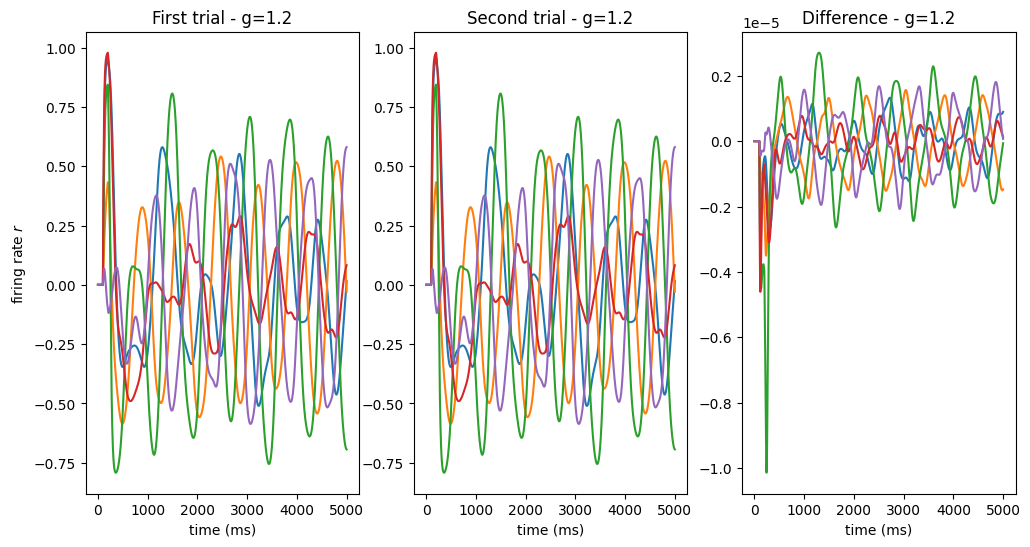

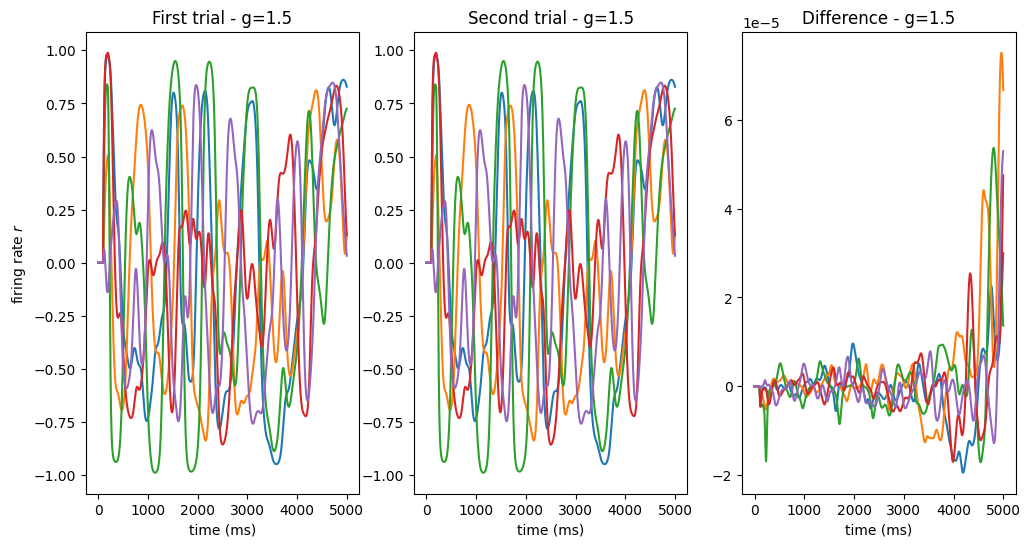

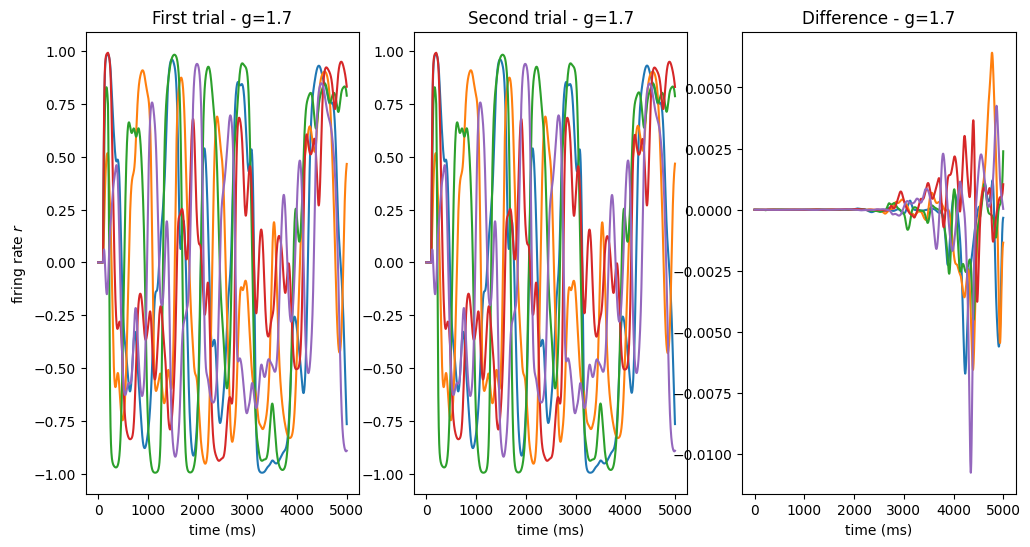

In [7]:
def plot_divergence(g, duration):
   
    data1 = net.trial(g=g, duration=duration, amplitude = 1.0)
    data2 = net.trial(g=g, duration=duration, amplitude = 1.00001)


    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(1, 3, 1)
    for n in range(5):
        ax.plot(data1[:, n])
    ax.set_title("First trial - g="+str(g))
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('firing rate $r$')

    ax = fig.add_subplot(1, 3, 2)
    for n in range(5):
        ax.plot(data2[:, n])
    ax.set_title("Second trial - g="+str(g))
    ax.set_xlabel('time (ms)')

    ax = fig.add_subplot(1, 3, 3)
    for n in range(5):
        ax.plot(data1[:, n] - data2[:, n])
    ax.set_title("Difference - g="+str(g))
    ax.set_xlabel('time (ms)')

    plt.show()

for g in [0.5, 1.0, 1.2, 1.5, 1.7]:
    plot_divergence(g=g, duration=5000)

**A:** A significant divergence between the two runs only occurs for $g>1.5$. This is the definition of chaos: a slight uncertainty on the initial conditions can have dramatic long-term effects.

Let's now use the reservoir as a spatiotemporal basis for supervised learning. We first need to define a target signal $t$ that will be used to train the weights of the readout population. We can use for example an impulse after 4 seconds as a target, but feel free to use whatever you want:

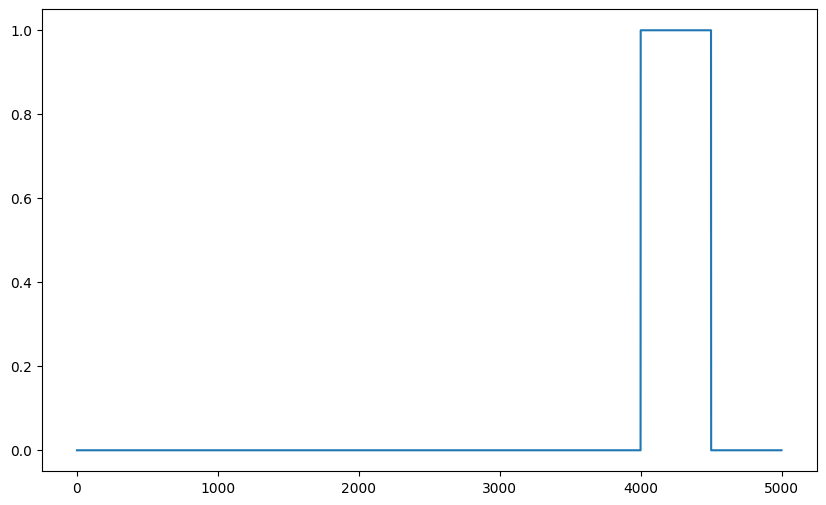

In [8]:
target = np.zeros(5000)
target[4000:4500] = 1.0

plt.figure(figsize=(10, 6))
plt.plot(target)
plt.show()

Instead of implementing a readout neuron and a linear regression / delta learning rule, we are going to make use of the `scikit-learn`'s linear regression implementation. 

If you have an input array `X` and a target array `t` (the first dimension of both arrays being samples), you can simply type:

```python
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, t)
```

Ridge regression (<https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html>) is another popular option.

You can then predict value for any other input array `X`:

```python
y = reg.pred(X)
```

**Q:** Train the linear regression algorithm on the activity of the reservoir as input. Samples are the firing rates of the reservoir at each time step (i.e. 5000 samples of dimension `N=500`). Test it on the same array and visualize the prediction. Can we linearly predict the target signal using an ESN? 

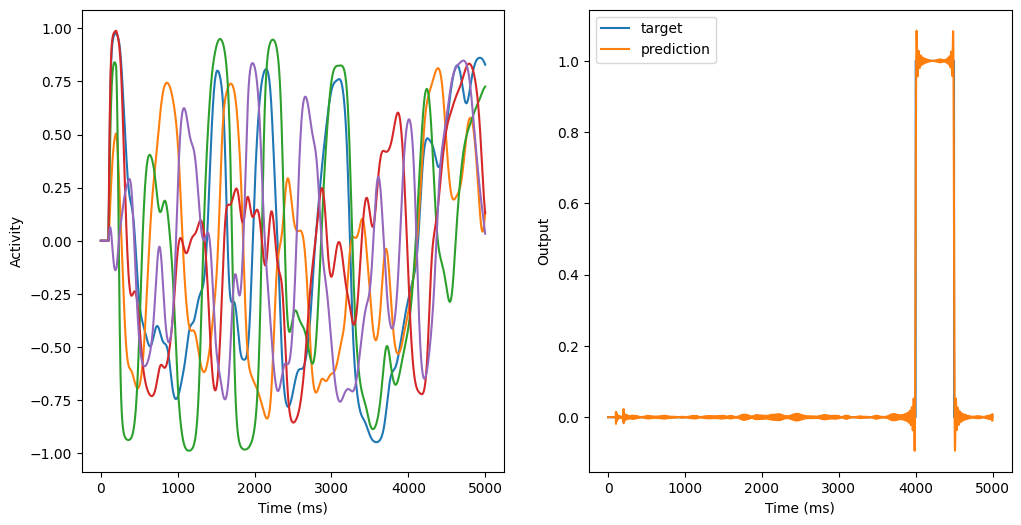

In [9]:
# Generate the trial
g = 1.5
data = net.trial(g=g, duration=5000, amplitude=1.0)

# Train a linear regressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(data, target)

# Perform the prediction
pred = reg.predict(data)

# Plot the prediction
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
for n in range(5):
    ax.plot(data[:, n])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Activity")

ax = fig.add_subplot(1,2,2)
ax.plot(target, label="target")
ax.plot(pred, label="prediction")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Output")
plt.legend()

**A:** Yes, for high values of g (above 1.5), it provides a good basis for the linear regression to correctly predict the target signal. Interestingly, when the reservoir settles on a stable attractor (g is 1.5 or even less), the regression still works, but there are a lot of oscillations.


**Q:** Test the learned regression on the activity of the reservoir, but using an input impulse of slightly different amplitude (e.g. 1.00001). Vary $g$. Does it still work? Conclude on the stability and usability of ESN reservoirs.

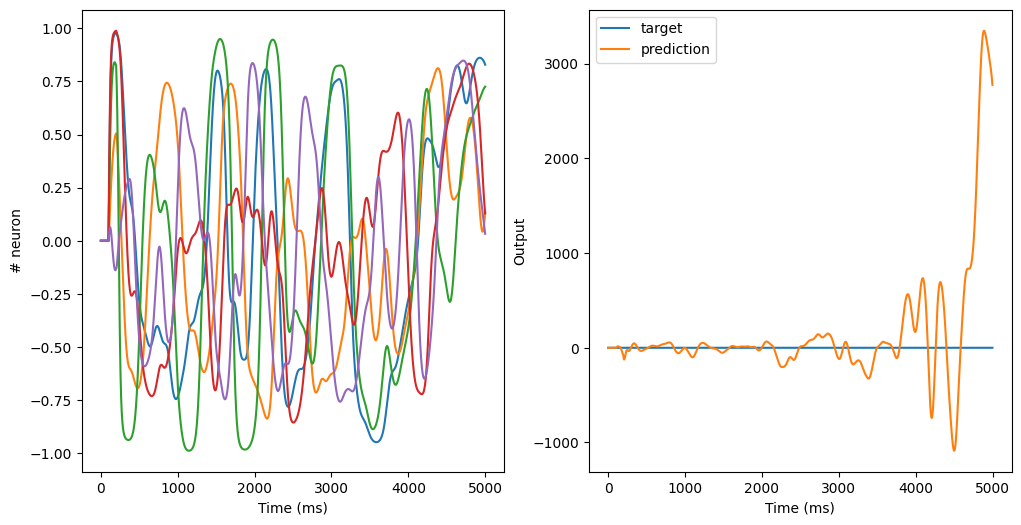

In [10]:
# Generate the second trials
data2 = net.trial(g=g, duration=5000, amplitude=1.00001)

# Perform the prediction
pred2 = reg.predict(data2)

# Plot the predictions
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
for n in range(5):
    ax.plot(data2[:, n])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("# neuron")

ax = fig.add_subplot(1, 2, 2)
ax.plot(target, label="target")
ax.plot(pred2, label="prediction")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Output")
plt.legend()

plt.show()

**A:** However, if we are too close from chaos, the slightest change in the initial impulse changes the complete trajectory of the reservoir (although not by much) and the regression does not work anymore (overfitting).